# Preprocess Google Streetview House Number Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import tarfile
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
import h5py
from PIL import Image
import PIL.Image as Image

In [3]:
DATA_PATH = Path('images', 'svhn')

In [4]:
results_path = Path('results', 'svhn')
if not results_path.exists():
    results_path.mkdir(parents=True)

Download the source data (Format 1) from [Stanford Deep Learning](http://ufldl.stanford.edu/housenumbers/) and place the extracted `train` and `test` folders in the directory `images/svhn`.

## Parse Bounding Box information

Adapted from [this](https://github.com/Bartzi/see/blob/master/datasets/svhn/svhn_dataextract_tojson.py) script.

In [5]:
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0]
                    for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self, n):
        s = self.getBbox(n)
        s['name'] = self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename': pictDat[i]["name"]}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

## Generate Datasets

In [6]:
def generate_dataset(data, path):
    n = len(data)
    dataset = np.ndarray([n, 32, 32, 3], dtype='float32')
    labels = np.ones([n, 6], dtype=int) * 10
    for i in range(n):
        if i % 5000 == 0:
            print(i, end=' ', flush=True)
        im = Image.open(path / data[i]['filename'])
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i, 0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5:
                labels[i, j + 1] = boxes[j]['label']
                if boxes[j]['label'] == 10:
                    labels[i, j + 1] = 0
            else:
                print('\n#', i, 'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']

        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        im_top = np.floor(im_top - 0.1 * im_height)
        im_left = np.floor(im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]])

        im = im.crop((im_left, im_top, im_right, im_bottom))
        im = np.array(im.resize([32, 32], Image.ANTIALIAS), dtype='float32')
        im = (im - 128) / 128
        dataset[i, :, :, :] = im[:, :, :]
    return dataset, labels

In [7]:
for folder in ['train', 'test']:
    print('\n', folder)
    target = DATA_PATH / folder / 'digitStruct.mat'
    dsf = DigitStructFile(target)
    data = dsf.getAllDigitStructure_ByDigit()
    dataset, labels = generate_dataset(data, DATA_PATH / folder)
    np.save(DATA_PATH / f'X_{folder}', dataset)
    np.save(DATA_PATH / f'y_{folder}', labels)


 train
0 5000 10000 15000 20000 25000 
# 29929 image has more than 5 digits.
30000 
 test
0 5000 10000 

## Plot sample images

In [8]:
X_train = np.load(DATA_PATH / 'X_train.npy')
y_train = np.load(DATA_PATH / 'y_train.npy')

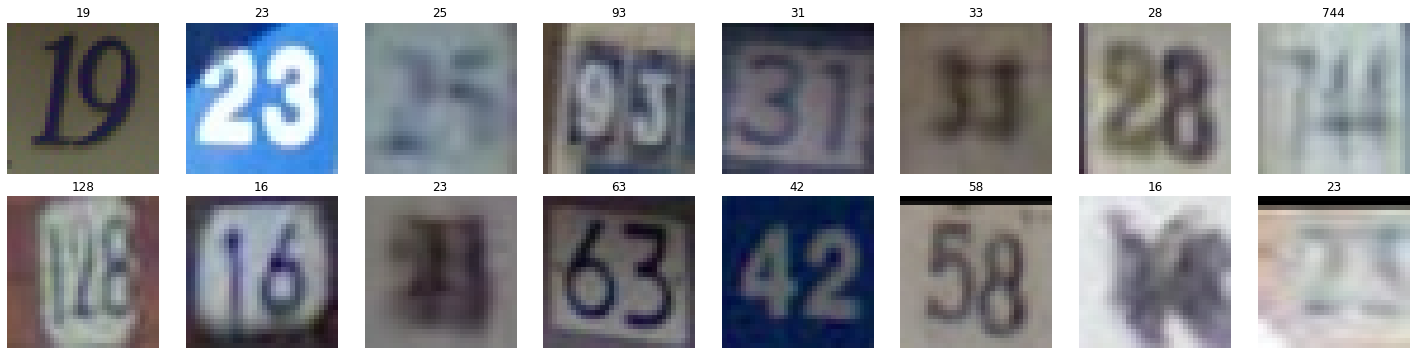

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze((X_train[i] * 128) + 128).astype(int))
    ax.axis('off')
    ax.set_title(''.join([str(d) for d in y_train[i][1:] if d < 10]))
fig.tight_layout()
fig.savefig(results_path / 'sample_img', dpi=300);